In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, curve_fit
import joblib as jl
import json
import glob
import matplotlib.cm as cm
import seaborn as sns


In [77]:
def load_log(p):
    log =jl.load(p)
    args = json.load(open('/'.join(p.split('/')[:-1]) + '/args.json', 'r'))    
    return log, args

def get_training_time(p, k, lrw1, lrw2, lrv):
    log, args = load_log(p)
    num_tasks = args['num_tasks']
    seq_length = args['seq_length']
    vs = args['vs']
    pretrain_num_iter = 0
    composite_num_iter = 0
    num_iter = 0
    overlap_tilde = None
    if args['max_iters'][0] == 0 and num_tasks==k and \
    args['lr_w1']== lrw1 and args['lr_w2']== lrw2 and args['lr_v']== lrv: ##Baseline case
        if log['composite'] is not None:
            threshold = log['composite']['threshold']
            num_iter = log['composite']['iter']
            overlap_tilde = log['composite']['overlap_tilde']

    elif num_tasks==k and \
    args['lr_w1']== lrw1 and args['lr_w2']== lrw2 and args['lr_v']== lrv:## Pretraining case
        if log['pretraining'] is not None:
            pretrain_threshold = log['pretraining']['threshold']
            pretrain_num_iter = log['pretraining']['iter']
            overlap = log['pretraining']['overlap_task']
        if log['composite'] is not None:
            composite_threshold = log['composite']['threshold']
            composite_num_iter = log['composite']['iter']
            overlap_tilde = log['composite']['overlap_tilde']
        
        num_iter = num_tasks * pretrain_num_iter + composite_num_iter
        
    
    return seq_length, tuple(vs), num_iter, overlap_tilde

def lr_hyperparams_search(rootpath, T, K, pretrain):
    
    def _pretrain_iter(log):
        
        if log['pretraining'] is not None:
            pretrain_threshold = log['pretraining']['threshold']
            pretrain_num_iter = log['pretraining']['iter']
            overlap = log['pretraining']['overlap_task']
        
            return pretrain_num_iter
        return np.inf 
    
    def _composite_iter(log):
        
        if log['composite'] is not None:
            composite_threshold = log['composite']['threshold']
            composite_num_iter = log['composite']['iter']
            overlap_tilde = log['composite']['overlap_tilde']
        
            return composite_num_iter
        
        return np.inf
    
        
    results_dict={}
    
    for p in glob.glob(rootpath):
        log, args = load_log(p)
        num_tasks = args['num_tasks']
        seq_length = args['seq_length']
        if num_tasks==K and seq_length==T:
            lr_w1= args['lr_w1']
            lr_w2= args['lr_w2']
            lr_v= args['lr_v']
            vs = tuple(args['vs'])
    
            pretrain_num_iter =  0
            if pretrain:
                pretrain_num_iter = _pretrain_iter(log)
                
            composite_num_iter = _composite_iter(log)
                
            num_iter = num_tasks * pretrain_num_iter + composite_num_iter
            
            if not vs in results_dict.keys():
                results_dict[vs] = {}
                
            else:
                results_dict[vs][(lr_w1, lr_w2, lr_v)] = num_iter
                
    best_dict= {}
    
    for k,v in results_dict.items():
        
        best_lr=list(v.keys())[np.argmin(list(v.values()))]
        best_iter = np.min(list(v.values()))
        assert best_iter == v[best_lr]
        
        best_dict[k] = (best_iter, best_lr)    
    return results_dict, best_dict


In [60]:
np.min([np.inf, 0, np.inf])

0.0

In [57]:
K=4
lrw1= 1.
lrw2 = 1.
lrv = 1.

In [83]:
baseline_rootpath = 'hrl_ode_logs/141223_baseline_training_time_controlled_vs/*/ode*'
curriculum_rootpath = 'hrl_ode_logs/141223_curriculum_training_time_controlled_vs/*/ode*'

T = 8
K = 4
baseline_hyperparam, best_baseline = lr_hyperparams_search(baseline_rootpath, T, K, False )
curriculum_hyperparam, best_curriculum = lr_hyperparams_search(curriculum_rootpath, T, K, True )

In [84]:
best_baseline

{(0.8, 0.1, 0.05, 0.05): (479440.0, (10.0, 1.0, 10.0)),
 (0.4, 0.3, 0.2, 0.1): (387440.0, (10.0, 1.0, 10.0)),
 (0.7, 0.1, 0.1, 0.1): (447239.0, (10.0, 1.0, 10.0))}

In [82]:
194230/148933

1.3041434739110875

In [85]:
best_curriculum

{(0.8, 0.1, 0.05, 0.05): (366994.0, (1.0, 1.0, 10.0)),
 (0.4, 0.3, 0.2, 0.1): (365480.0, (1.0, 1.0, 10.0)),
 (0.7, 0.1, 0.1, 0.1): (366582.0, (1.0, 1.0, 10.0))}

In [11]:
baseline_training_time = {}
for baseline_p in glob.glob('hrl_ode_logs/141223_baseline_training_time_controlled_vs/*/ode*'):
    seq_length, vs, num_iter, overlap_tilde=get_training_time(baseline_p,K, lrw1, lrw2, lrv)
    if num_iter !=0:
        if (vs, seq_length) not in baseline_training_time.keys():
            baseline_training_time[( vs, seq_length)] = np.array([[num_iter, overlap_tilde]])
        else:
            baseline_training_time[(vs, seq_length)]=np.vstack([baseline_training_time[(vs, seq_length)], 
                                                                        [num_iter, overlap_tilde]])

In [13]:
curriculum_training_time = {}
for curriculum_p in glob.glob('hrl_ode_logs/141223_curriculum_training_time_controlled_vs/*/ode*'):
    seq_length, vs, num_iter, overlap_tilde=get_training_time(curriculum_p,K, lrw1, lrw2, lrv)
    if num_iter !=0:
        if (vs, seq_length) not in curriculum_training_time.keys():
            curriculum_training_time[( vs, seq_length)] = np.array([[num_iter, overlap_tilde]])
        else:
            curriculum_training_time[(vs, seq_length)]=np.vstack([curriculum_training_time[(vs, seq_length)], 
                                                                        [num_iter, overlap_tilde]])

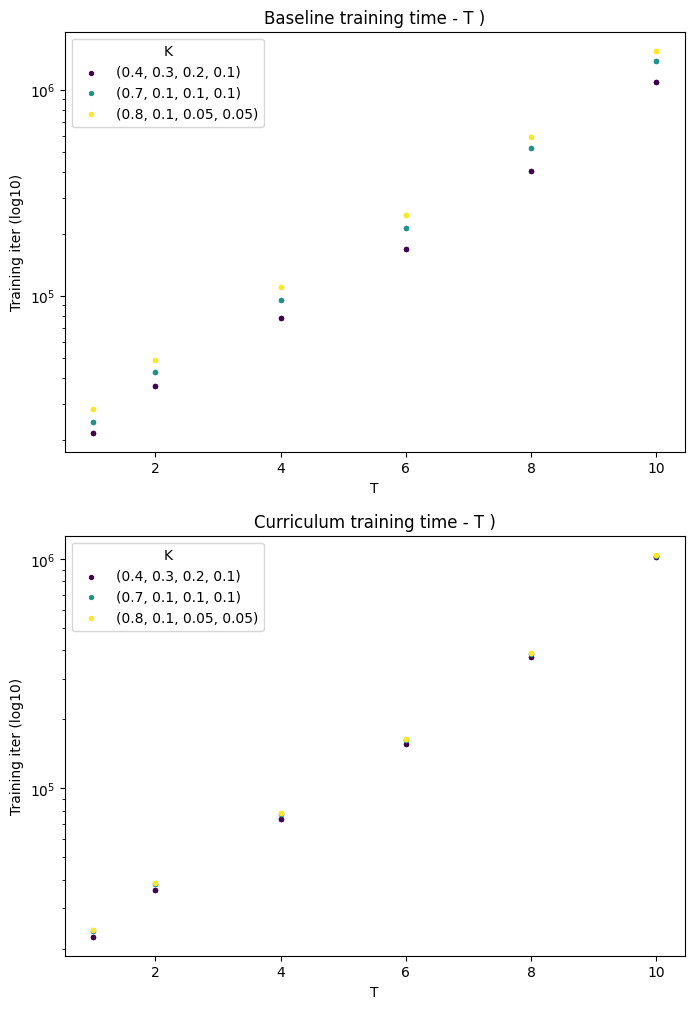

In [14]:
vs_dic= {tuple(item):n for n,item in enumerate(np.unique([list(k[0]) for k in curriculum_training_time.keys()], axis=0))}

fig = plt.figure(figsize=(8,12))
ax1 = plt.subplot(211)
cmap1=cm.viridis(range(0, len(vs_dic.keys()))/np.mean(range(0, len(vs_dic.keys())))/2)
handles =[]
for i, vs_init in enumerate(vs_dic.keys()):
    time_list=[[k[1],v[:,0]] for k, v in baseline_training_time.items() if k[0] == vs_init]
    for seq_score in time_list:
        seq_length=seq_score[0]
        iter_nums = seq_score[1]
        seq=ax1.scatter([seq_length]*len(iter_nums), iter_nums, color = cmap1[i], s=8, label = vs_init)
    handles.append(seq)
    ax1.legend(handles = handles, title = 'K')
ax1.set_xlabel('T')
ax1.set_ylabel('Training iter (log10)')
ax1.set_title(f'Baseline training time - T )')
ax1.set_yscale('log')

ax2 = plt.subplot(212)
handles =[]
for i, vs_init in enumerate(vs_dic.keys()):
    time_list=[[k[1],v[:,0]] for k, v in curriculum_training_time.items() if k[0] == vs_init]
    for seq_score in time_list:
        seq_length=seq_score[0]
        iter_nums = seq_score[1]
        seq=ax2.scatter([seq_length]*len(iter_nums), iter_nums, color = cmap1[i], s=8, label = vs_init)
    handles.append(seq)
    ax2.legend(handles = handles, title = 'K')
ax2.set_xlabel('T')
ax2.set_ylabel('Training iter (log10)')
ax2.set_title(f'Curriculum training time - T )')
ax2.set_yscale('log')


In [15]:
vs_init_list =np.unique([list(k[0]) for k in curriculum_training_time.keys()], axis=0)
seq_length_list =np.unique([k[1] for k in curriculum_training_time.keys()])


difference_percent={k: np.mean(v[:,0])/np.mean(curriculum_training_time[k][:,0]) for k,v in baseline_training_time.items() if k in curriculum_training_time.keys()}
difference_percent_heatmap = np.empty((len(vs_init_list), 6))


for i,vs in enumerate(vs_init_list):
    for j, seq in enumerate(seq_length_list):
        try:
            difference_percent_heatmap[i][j] = difference_percent[(tuple(vs),seq)]
        except:
            pass
        

In [16]:
vs_init_list

array([[0.4 , 0.3 , 0.2 , 0.1 ],
       [0.7 , 0.1 , 0.1 , 0.1 ],
       [0.8 , 0.1 , 0.05, 0.05]])

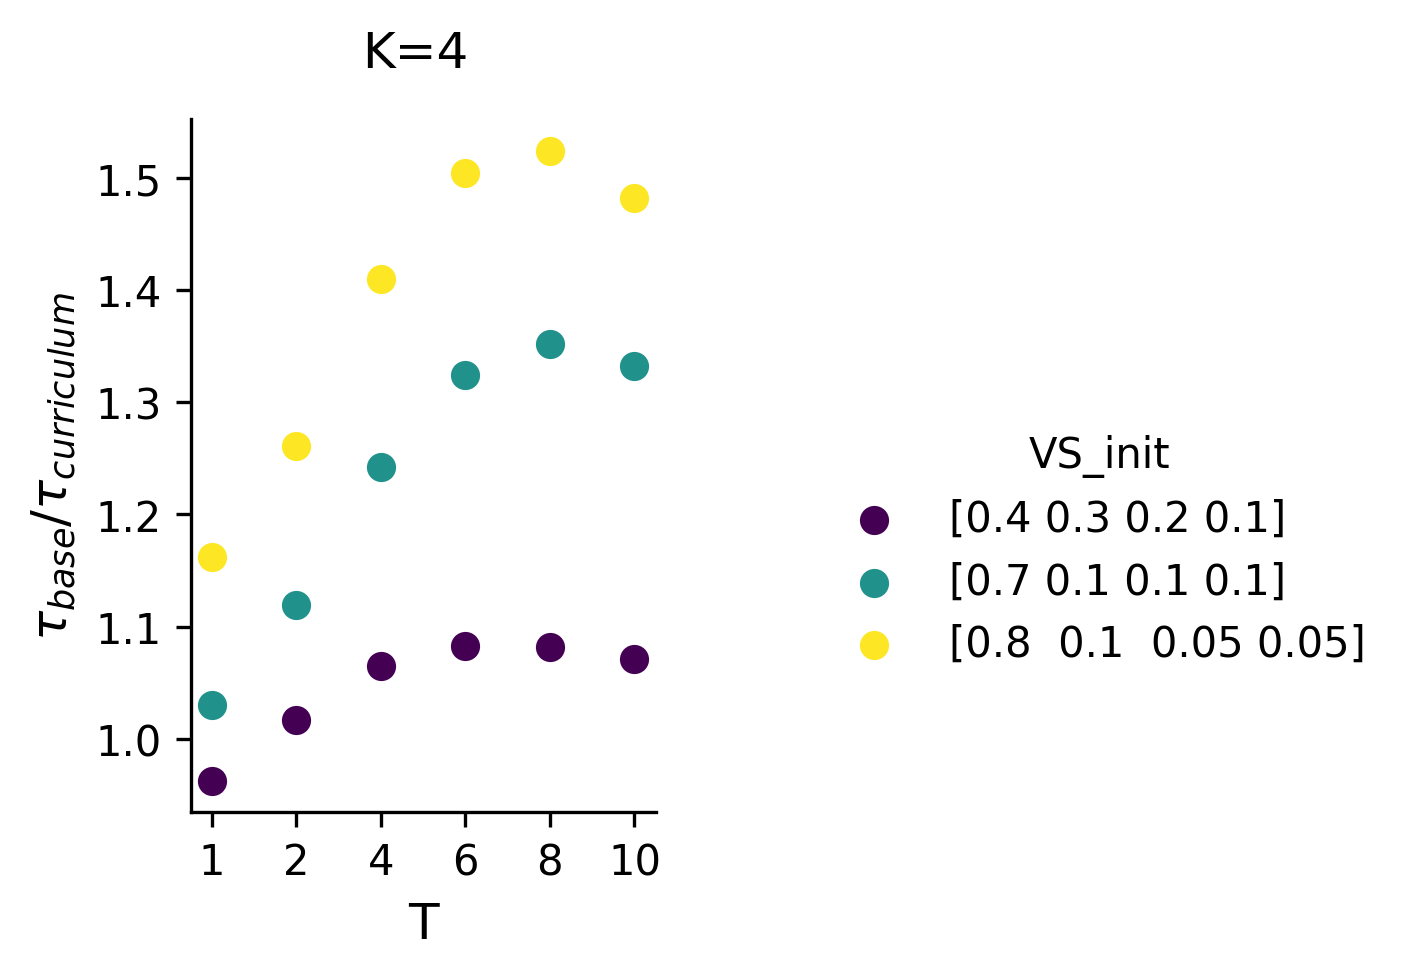

In [17]:
fig = plt.figure(figsize=(2,3), dpi = 300)
ax1 = plt.subplot(111)
plt.suptitle(f'K={K}')
handles=[]
cmap=cm.viridis(range(0, len(vs_init_list))/np.mean(range(0, len(vs_init_list)))/2)
for i in range(difference_percent_heatmap.shape[0]):
    for j in range(difference_percent_heatmap.shape[1]):
        task = ax1.scatter(j, difference_percent_heatmap[i,j], color = cmap[i], label = vs_init_list[i]) ## i: task, j : seq_len
    handles.append(task)

ax1.set_xlabel('T', fontsize=12)
ax1.set_ylabel(r'$\tau_{base}/\tau_{curriculum}$', fontsize=12) 
ax1.set_xticks(np.arange(len(seq_length_list)), seq_length_list)
ax1.legend(handles = handles, title = 'VS_init', frameon = False, bbox_to_anchor = (1.3, 0.6))

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

/nfs/nhome/live/jlee/.conda/envs/composite_learning/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(0.8, 1.6)

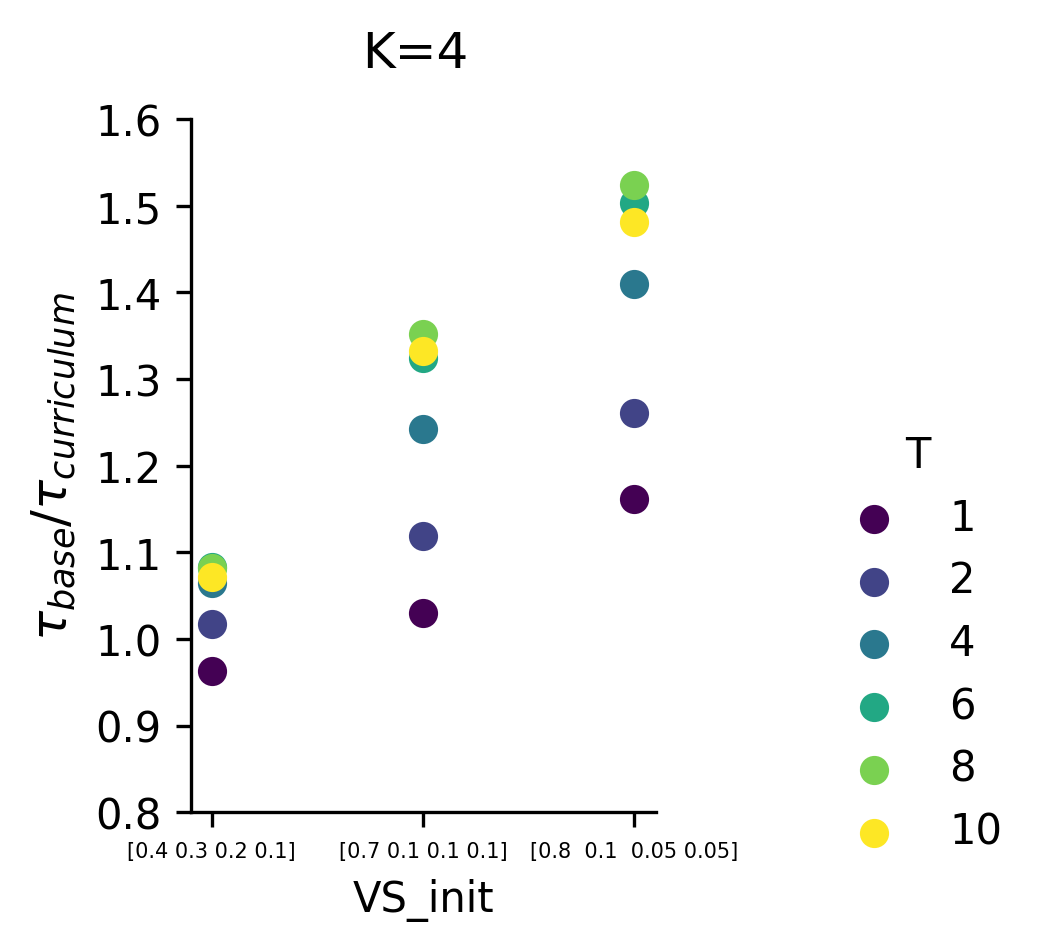

In [18]:
fig = plt.figure(figsize=(2,3), dpi = 300)
ax1 = plt.subplot(111)
plt.suptitle(f'K={K}')
handles=[]
cmap=cm.viridis(range(0, len(seq_length_list))/np.mean(range(0, len(seq_length_list)))/2)
for i in range(difference_percent_heatmap.shape[1]):
    for j in range(difference_percent_heatmap.shape[0]):
        task = ax1.scatter(j, difference_percent_heatmap[j,i], color = cmap[i], label = seq_length_list[i]) ## i: task, j : seq_len
    handles.append(task)

ax1.set_xlabel('VS_init', fontsize=10)
ax1.set_ylabel(r'$\tau_{base}/\tau_{curriculum}$', fontsize=12) 
ax1.set_xticks(np.arange(len(vs_init_list)), vs_init_list, fontsize=5)
ax1.legend(handles = handles, title = 'T', frameon = False, bbox_to_anchor = (1.3, 0.6))

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylim(0.8, 1.6)